In [1]:
# environment: thesisPlayground_pointClouds_env

In [2]:
import h5py
import numpy as np
import open3d as o3d
import pandas as pd
import glob
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Using depths

Hints on how to deal with this problem from:
- https://github.com/apple/ml-hypersim/issues/9

In [3]:
def get_depths_oneImage(file_path, intWidth = 1024, intHeight = 768, fltFocal = 886.81): # TODO: understand fltFocal

    with h5py.File(file_path, 'r') as file:
        # Access the dataset
        dataset = file['dataset']
        
        # Read the data from the dataset
        data = dataset[:]
        
        # Define a list of 2D points (row, column) to get the depth values for
        points = [(y, x) for y in range(intHeight) for x in range(intWidth)]
        
        # Get the depth values for the specified points
        npyDistances_array = [data[y, x] for y, x in points]
        
        # Apply transformation (Euclidean distance in meters to the optical center of the camera -> distances wrt the plane of the camera)
        npyImageplaneX = np.linspace((-0.5 * intWidth) + 0.5, (0.5 * intWidth) - 0.5, intWidth).reshape(1, intWidth).repeat(intHeight, 0).astype(np.float32)[:, :, None]
        npyImageplaneY = np.linspace((-0.5 * intHeight) + 0.5, (0.5 * intHeight) - 0.5, intHeight).reshape(intHeight, 1).repeat(intWidth, 1).astype(np.float32)[:, :, None]
        npyImageplaneZ = np.full([intHeight, intWidth, 1], fltFocal, np.float32)
        npyImageplane = np.concatenate([npyImageplaneX, npyImageplaneY, npyImageplaneZ], 2)

        npyDistances = np.array(npyDistances_array)
        npyDistances = npyDistances.reshape(768, 1024)

        npyDepths = npyDistances / np.linalg.norm(npyImageplane, 2, 2) * fltFocal

        return npyDepths
    
  

def get_depths(path_list):
    '''Each element of depth_files will be a representation of an image'''
    
    depth_files = []
    for i in range(len(path_list)):
        depth_files.append(get_depths_oneImage(path_list[i]))

    return depth_files


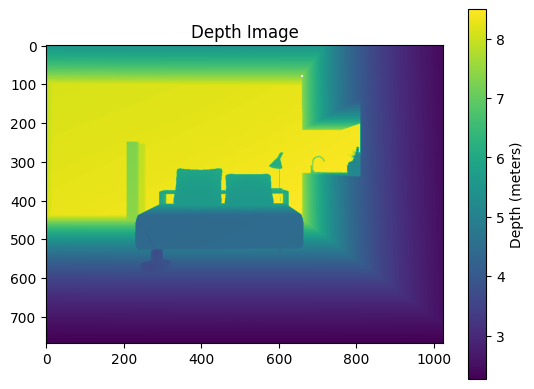

In [4]:
# TEST on one image
import matplotlib.pyplot as plt

file_path = '/local/home/gmarsich/data2TB/Hypersim/evermotion_dataset/scenes/ai_007_008/images/scene_cam_00_geometry_hdf5/frame.0000.depth_meters.hdf5'
depth_files = get_depths_oneImage(file_path)

plt.imshow(depth_files, cmap='viridis')  # Choose a colormap suitable for depth visualization
plt.colorbar(label='Depth (meters)')  # Add a colorbar to show depth values
plt.title('Depth Image')  # Add a title to the plot
plt.show()


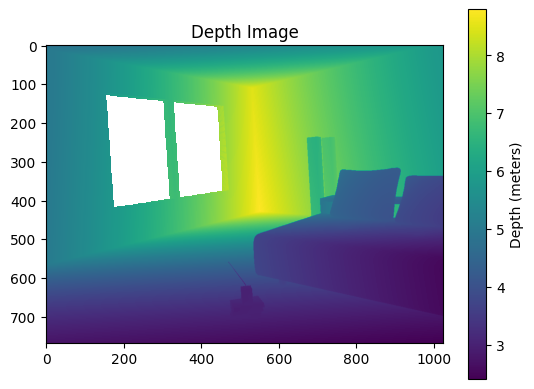

In [5]:
# TEST on another image
import matplotlib.pyplot as plt

file_path = '/local/home/gmarsich/data2TB/Hypersim/evermotion_dataset/scenes/ai_007_008/images/scene_cam_00_geometry_hdf5/frame.0030.depth_meters.hdf5'
depth_files = get_depths_oneImage(file_path)

plt.imshow(depth_files, cmap='viridis')  # Choose a colormap suitable for depth visualization
plt.colorbar(label='Depth (meters)')  # Add a colorbar to show depth values
plt.title('Depth Image')  # Add a title to the plot
plt.show()


One remarks that something appears strange. As a matter of fact, the coordiante system is that of the camera, not the "absolute" one.

In [6]:
def get_extrinsics_oneImage(path_positions, path_orientations, frame_id):
    """
    Load camera position and orientation from HDF5 files and compute the extrinsic matrix.

    Parameters:
        path_positions (str): Path to the camera positions HDF5 file.
        path_orientations (str): Path to the camera orientations HDF5 file.
        frame_id (int): Frame ID to extract the extrinsics for.

    Returns:
        np.ndarray: The extrinsic matrix [R|t].
    """

    # Load camera position
    with h5py.File(path_positions, "r") as f:
        camera_positions = f["dataset"][:]
    
    # Load camera orientation
    with h5py.File(path_orientations, "r") as f:
        camera_orientations = f["dataset"][:]
    
    # Get position and rotation matrix for the specified frame
    camera_position_world = camera_positions[frame_id]
    R_world_from_cam = camera_orientations[frame_id]

    # Construct the extrinsic matrix [R|t]
    extrinsic_matrix = np.hstack((R_world_from_cam, camera_position_world.reshape(3, 1)))
    
    return extrinsic_matrix


def get_extrinsics(path_positions, path_orientations, frames_id):
    extrinsics = []
    for i in range(len(frames_id)):
        extrinsics.append(get_extrinsics_oneImage(path_positions, path_orientations, frames_id[i]))

    return extrinsics

# # Example usage

# base_path = '/local/home/gmarsich/data2TB/Hypersim/evermotion_dataset/scenes'
# scene = 'ai_007_008'  # name of the scene, with format ai_VVV_NNN
# cam_xx = 'cam_00'

# # Get list of image and depth HDF5 files
# camera_positions = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_positions.hdf5')
# camera_orientations = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_orientations.hdf5')
# frame_id = 0  # Change this to the appropriate frame ID

# extrinsic_matrix = get_extrinsics(camera_positions, camera_orientations, frame_id)
# print("Extrinsic Matrix [R|t]:\n", extrinsic_matrix)

In [7]:
def get_intrinsics_from_metadata_COMPLETE(scene_row):
    """
    Derive the intrinsic matrix from metadata.

    Parameters:
        scene_row (pd.Series): Metadata row for the scene.

    Returns:
        np.ndarray: The intrinsic matrix K.
    """

    # Extract the necessary parameters from the metadata
    img_width = scene_row["settings_output_img_width"]
    img_height = scene_row["settings_output_img_height"]
    focal_length = scene_row["camera_physical_focal_length"]
    sensor_width = scene_row["camera_physical_film_width"]

    # Calculate fx and fy using the focal length and sensor width
    fx = focal_length / sensor_width * img_width
    fy = fx  # Assuming square pixels

    # Calculate the principal point (cx, cy) considering horizontal and vertical shifts
    cx = img_width / 2 + scene_row["camera_physical_horizontal_shift"]
    print('img_width: ', img_width)
    print('camera_physical_horizontal_shift":', scene_row["camera_physical_horizontal_shift"])
    cy = img_height / 2 + scene_row["camera_physical_lens_shift"]
    print('img_height : ', img_height )
    print('camera_physical_lens_shift":', scene_row["camera_physical_lens_shift"])

    # Construct the intrinsic matrix
    intrinsic_matrix = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])
    
    return intrinsic_matrix



def get_intrinsics_with_tilt_shift_COMPLETE(path_metadata, scene_name):
    """
    Load camera metadata from a CSV file and compute the intrinsic matrix considering tilt-shift parameters.

    Parameters:
        path_metadata (str): Path to the metadata CSV file.
        scene_name (str): Name of the scene to analyze.

    Returns:
        np.ndarray: The updated intrinsic matrix K.
    """
    
    # Load the metadata CSV file
    df = pd.read_csv(path_metadata)
    
    # Filter the DataFrame to get the row corresponding to the specified scene
    scene_row = df[df['scene_name'] == scene_name]
    
    if scene_row.empty:
        raise ValueError(f"Scene '{scene_name}' not found in the metadata.")
    
    # Use the first matching row
    scene_row = scene_row.iloc[0]
    
    # Get the intrinsic matrix from metadata
    intrinsic_matrix = get_intrinsics_from_metadata_COMPLETE(scene_row)
    
    return intrinsic_matrix



def load_hdf5_file(file_paths, dataset_key):
    data = []
    for file in file_paths:
        with h5py.File(file, 'r') as f:
            data.append(np.array(f[dataset_key]))
    return data


# Function to extract frame ID from filename
def extract_frame_id(filename):
    """
    Extract the frame ID from the filename.
    
    Parameters:
        filename (str): The filename from which to extract the frame ID.
    
    Returns:
        int: The extracted frame ID.
    """
    # Split the filename by '.' and take the second part
    frame_id_str = filename.split('.')[1]
    return int(frame_id_str)



def generate_point_cloud(depth_image, intrinsic_matrix, extrinsic_matrix):
    """
    Generate a point cloud from a depth image, intrinsic matrix, and extrinsic matrix.

    Parameters:
        depth_image (np.ndarray): Depth image with distances from the camera plane.
        intrinsic_matrix (np.ndarray): Intrinsic matrix of the camera.
        extrinsic_matrix (np.ndarray): Extrinsic matrix of the camera [R|t].

    Returns:
        np.ndarray: Point cloud in world coordinates, shape (N, 3) where N is the number of points.
    """
    # Get the dimensions of the depth image
    height, width = depth_image.shape
    
    # Create a grid of (u, v) coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    
    # Flatten the u, v coordinates and depth image
    u_flat = u.flatten()
    v_flat = v.flatten()
    depth_flat = depth_image.flatten()
    
    # Compute the 3D coordinates in the camera frame
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]
    
    x = (u_flat - cx) * depth_flat / fx
    y = (v_flat - cy) * depth_flat / fy
    z = depth_flat
    
    # Stack the 3D points in camera coordinates
    points_camera = np.vstack((x, y, z, np.ones_like(x)))
    
    # Transform points to world coordinates using the extrinsic matrix
    points_world = extrinsic_matrix @ points_camera
    
    # Drop the homogeneous coordinate
    points_world = points_world[:3, :].T
    
    return points_world




def render_point_cloud(point_cloud):
    # Create Open3D point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud.reshape(-1, 3))  # Reshape the array to 3D points

    # Create Open3D visualizer object
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # Add the point cloud to the visualization window
    vis.add_geometry(pcd)

    # Set the render options (optional)
    render_options = vis.get_render_option()
    render_options.point_size = 1.0  # Adjust point size if needed

    # Run the visualizer
    vis.run()
    vis.destroy_window()


In [8]:
path_metadata = '/local/home/gmarsich/Desktop/Thesis/0Code_playground/pointClouds/pointClouds_ChatGPT/withDepths/metadata_camera_parameters.csv'
base_path = '/local/home/gmarsich/data2TB/Hypersim/evermotion_dataset/scenes'
scene = 'ai_007_008'  # name of the scene, with format ai_VVV_NNN
cam_xx = 'cam_00'

# Get list of image and depth HDF5 files
image_files = sorted(glob.glob(os.path.join(base_path, scene, 'images', 'scene_' + cam_xx + '_final_hdf5', '*.color.hdf5')))
depthEuclidean_files = sorted(glob.glob(os.path.join(base_path, scene, 'images', 'scene_' + cam_xx + '_geometry_hdf5', '*.depth_meters.hdf5')))

positions_path = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_positions.hdf5')
orientation_path = os.path.join(base_path, scene, '_detail', cam_xx, 'camera_keyframe_orientations.hdf5')

# Ensure the number of image and depth files match
if len(image_files) != len(depthEuclidean_files):
    raise ValueError("The number of image files and depth files do not match.")

In [9]:
# Load images data
images = load_hdf5_file(image_files, 'dataset')

# Get the intrinsic matrix for the scene
intrinsics = get_intrinsics_with_tilt_shift_COMPLETE(path_metadata, scene)
print("Intrinsic Matrix for the scene:")
print(intrinsics)

# Get the extrinsics matrix for the scene
depthEuclidean_files_id = [extract_frame_id(os.path.basename(file)) for file in depthEuclidean_files]
extrinsics = get_extrinsics(positions_path, orientation_path, depthEuclidean_files_id)
print("Extrinsics Matrix for the scene:")
print(extrinsics[0])

# Get the depths from the plane (and not the distances from the camera)
depth_files = get_depths(depthEuclidean_files)

# Generate point clouds for each view
point_clouds = generate_point_cloud(depth_files[0], intrinsics, extrinsics)


# render_point_cloud(point_clouds)

img_width:  1024.0
camera_physical_horizontal_shift": 0.0
img_height :  768.0
camera_physical_lens_shift": -0.0799999982118606
Intrinsic Matrix for the scene:
[[1.43810735e+03 0.00000000e+00 5.12000000e+02]
 [0.00000000e+00 1.43810735e+03 3.83920000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsics Matrix for the scene:
[[ 9.99448895e-01  2.52561085e-03 -3.30993086e-02  7.81024837e+00]
 [-3.31955254e-02  7.60409459e-02 -9.96551991e-01 -2.44333206e+02]
 [ 0.00000000e+00  9.97101486e-01  7.60828778e-02  4.44449768e+01]]


In [10]:
render_point_cloud(point_clouds)